## Examples for model-agnostic image explanations with LIME

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from lime import lime_image
import shap
from skimage.segmentation import mark_boundaries

2022-03-22 11:14:45.230323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 11:14:45.230347: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load exemplary model and data

In [2]:
model = ResNet50(weights='imagenet')
X, y = shap.datasets.imagenet50()

2022-03-22 11:14:48.270012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-22 11:14:48.270051: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-22 11:14:48.270078: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (michael): /proc/driver/nvidia/version does not exist
2022-03-22 11:14:48.270310: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Get a summary from the model

In [3]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## Obtain Class names

In [4]:
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
#print("Number of ImageNet classes:", len(class_names))
#print("Class names:", class_names)

### Plot one of the Images

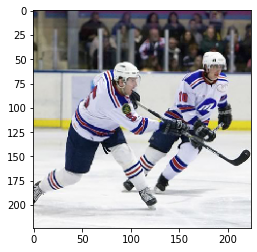

In [5]:
plt.imshow(X[3:4].squeeze()/255.0)

## Apply LIME

In [6]:
# initialize Lime Image Explainer
explainer = lime_image.LimeImageExplainer()

In [7]:
# we need to define a predict function LIME 

# Squeeze the dimensions of the images from (1, 224, 224, 3) to (224, 224, 3) 
def lime_transform(x):
    return x.squeeze()

# Predict class probabilties for the inputs
def f_lime(x):
    tmp = x.copy()
    preprocess_input(tmp)
    if len(tmp.shape)==3:
        tmp = tmp[None,:,:,:]
    return model(tmp)

## Generate a LIME explainer

In [8]:
explanation = explainer.explain_instance(
lime_transform(X[3:4]), # image to be explained
f_lime, # function (classifier to be explainer)
top_labels=5, # number of labels for which we want to get explanations
num_samples=1000 # number of random draws from the superpixel mask
)

  0%|          | 0/1000 [00:00<?, ?it/s]2022-03-22 11:14:52.403704: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32112640 exceeds 10% of free system memory.
2022-03-22 11:14:52.447226: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32112640 exceeds 10% of free system memory.
2022-03-22 11:14:52.458919: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32112640 exceeds 10% of free system memory.
2022-03-22 11:14:52.468015: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32112640 exceeds 10% of free system memory.
2022-03-22 11:14:52.473334: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33269760 exceeds 10% of free system memory.
  2%|▏         | 20/1000 [00:01<01:21, 12.06it/s]

In [ ]:
# Show the top_labels (i.e., the labels with the highest class probability)

for i in explanation.top_labels:
    print(class_names[i])

puck
knee_pad
football_helmet
ballplayer
basketball


## Show the most relevant superpixels for the top labels

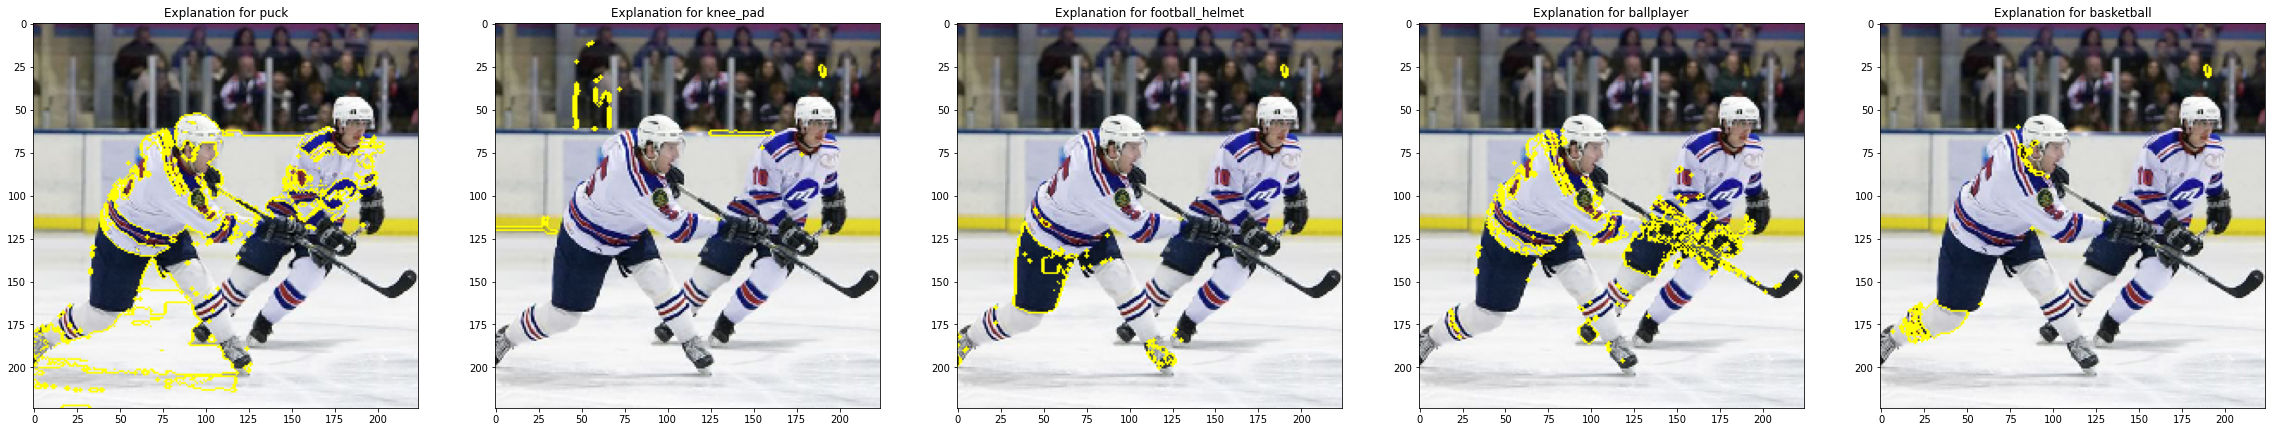

In [ ]:
fix, ax = plt.subplots(1,5, figsize=(40,40))

for i in range(5):
    temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[i], # select the relevant explainer
    positive_only=True, # show only those patches that contribute to the respective class
    num_features=5, # numer of indicative superpixels
    hide_rest=False # whether oly the superpixels or the whole image should be shown
    )

    ax[i].imshow(mark_boundaries(temp/255.0, mask))
    ax[i].set_title('Explanation for ' + class_names[explanation.top_labels[i]])

# Exercises

### Try the generation of Explanations for other pictures, e.g., X[20:21]

### Change the hyperparamters in order to see their effec

### Go to https://github.com/marcotcr/lime and try their tutorial